# Cluster drawing to create samples from it
Previous attemps to learn on entire drawing was unsuccessfull, so I decided to move to new approach.
I.e. i will try to create a cluster of lines from the drawing that will be a learning sample x.
Than we will calculate some distance from cluster to dimensions on the drawing to attribute each dimension with the cluster. That attribution will be our Y.

In [1]:
# Start with basic example of unsupervised clustering with unknown number of clusters
# https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py

In [2]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [3]:
import pymongo
import pandas as pd
from pymongo import MongoClient

import matplotlib.pyplot as plt
%matplotlib inline

import torch

# from processing import *

In [4]:
client = MongoClient('mongodb://192.168.0.106:27017')
db = client.geometry

fileids  = db.files.find({'Valid':True}).distinct('FileId')
print('files count', len(fileids))

# all the data will be too much for now, so we will take say 42 files:
fileids = fileids[:22]

query = {
    'ClassName':
    {
        '$in':[
            'AcDbLine',
            #'AcDbPolyline',
            'AcDbText',
            'AcDbRotatedDimension'
        ]
    },
    'FileId':{
        '$in':fileids
    }
}

data = pd.DataFrame(list(db.objects.find(query)))
print('data length', len(data))

files count 322
data length 49545


# Split data coordinates to columns

In [5]:
from processing import Col2Numpy

groupped = data.groupby(['FileId'])
column_names = ['StartPoint', 'EndPoint', 'XLine1Point', 'XLine2Point']

# Whole point here is that we're keeping index from the original dataset in file_points

file_points = {} #dic[FileId]list_Of_Points
# all file ids
file_ids = list(groupped.groups.keys())
for file_id in file_ids:
    pnts = Col2Numpy(groupped.get_group(file_id), column_names)
    # print(pnts)
    file_points[file_id]=pnts

num_points = 0
for k in file_points:
    num_points += len(file_points[k])
print('Total number of points: ', num_points)

Total number of points:  90100


# Implement and check clustering algorithm

In [6]:
def Clusterize(x, eps = 0.2):
    '''
    The very basic clustering with unknown number of clusters
    https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
    '''
    
    # algorithm='kd_tree'
    db = DBSCAN(eps=eps, min_samples=6, n_jobs=-1).fit(x)
    labels = db.labels_
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    return labels, n_clusters, n_noise, db.core_sample_indices_

# Test and display clustering result

In [7]:
from plot_graphics import draw_set
from processing import scale_ds


def AddLabels2Dataset(points_of_one_file, df_to_export_labels, fileid_to_print="", epses=0.2):
    result = df_to_export_labels
    
    # split indexes from coordinates
    x1, data_indexes = np.split(points_of_one_file,[3], axis = 1)
    data_indexes = data_indexes.astype('int')
    
    # print(x1)
    # scale dataframe in order to clusterize it properly
    x1, scl = scale_ds(x1)
    
    # for now we will magically assign eps on base of scale
    epses = 15*scl
    
    # epses could be a number or list of numbers
    # I use list of numbers in order
    # to visually assess clustering
    ep = epses
    if type(epses) != list:
        ep=[epses]
        
    for eps in ep:
        # perform clustering of points to calculate labels
        
        labels, n_clusters, n_noise, core_indices = Clusterize(x1, eps=eps)

        # print(len(x1), len(labels))
        # draw_set(x1, labels, core_indices)  

        print("fileid:{} points:{} clusters:{} noise pnts:{} eps:{:0.3f} scale:{:0.6f}".format(
              fileid_to_print,
              x1.shape[0], 
              n_clusters,
              n_noise, 
              eps,
              scl))
    
    data_indexes['label'] = labels

    # https://stackoverflow.com/questions/22918212/fastest-way-to-drop-duplicated-index-in-a-pandas-dataframe
    # data_indexes = data_indexes.drop_duplicates('id')
    data_indexes = data_indexes.groupby(data_indexes.index).first()
    
    for i in range(len(data_indexes.index)):
        indx = data_indexes.index[i]
        # https://stackoverflow.com/questions/13021654/get-column-index-from-column-name-in-python-pandas
        result.iloc[indx, result.columns.get_loc('label')] = data_indexes.iloc[i, data_indexes.columns.get_loc('label')]    
    print(len(result.loc[result['label'] == -1]))
    return result

In [8]:
labeled_data = pd.DataFrame(data)
labeled_data['label'] = -1

i = 0
for file_id, _x1 in file_points.items():
    #print(df.groupby(['FileId', 'label']).count())
    #df = df.join(data_indexes, on=['id'], how='left', rsuffix='_r')
    labeled_data = AddLabels2Dataset(
        points_of_one_file=_x1, 
        df_to_export_labels=labeled_data, 
        fileid_to_print=file_id,
        epses=[0.04, 0.05]
    )
    
    i+=1
    if i>3:
        #debug break
        pass

fileid:006cb2dd-6f18-4203-8b70-fc865c08105a points:790 clusters:8 noise pnts:56 eps:0.025 scale:0.001698
49177
fileid:006f290c-7280-491b-b7d7-971ed82de1a5 points:662 clusters:4 noise pnts:61 eps:0.025 scale:0.001698
48877
fileid:0100c16b-c7c9-4265-92b9-950bf5d2c9ec points:362 clusters:6 noise pnts:61 eps:0.025 scale:0.001698
48725
fileid:013edfac-9865-4422-a5f2-3220d142116d points:2130 clusters:20 noise pnts:81 eps:0.036 scale:0.002410
47694
fileid:01ea3780-b297-4075-8a26-77461e995b7d points:7114 clusters:47 noise pnts:218 eps:0.000 scale:0.000004
44237
fileid:01f9cbe6-c14f-4dc0-817e-4d80380d4e26 points:2558 clusters:58 noise pnts:204 eps:0.018 scale:0.001197
43054
fileid:02401882-a7cc-47ad-b8c2-c38eb9be323b points:1534 clusters:13 noise pnts:72 eps:0.025 scale:0.001698
42323
fileid:024be99c-0302-43b3-92b3-aa0aba5a376a points:1416 clusters:32 noise pnts:215 eps:0.018 scale:0.001196
41710
fileid:02580ab5-a831-4845-a46a-874a6fce6230 points:1008 clusters:18 noise pnts:215 eps:0.018 scale:

In [9]:
print("total data length:", len(labeled_data))
print("unlabeled data length:",len(labeled_data.loc[labeled_data['label'] == -1]))

total data length: 49545
unlabeled data length: 21430


In [10]:
from processing import expand_columns

df = pd.DataFrame(labeled_data)
df = expand_columns(df, column_names)
x_columns = ['StartPoint.X', 'StartPoint.Y', 'StartPoint.Z',
             'EndPoint.X', 'EndPoint.Y', 'EndPoint.Z']
y_columns = ['XLine1Point.X', 'XLine1Point.Y','XLine1Point.Z', 
    'XLine2Point.X', 'XLine2Point.Y', 'XLine2Point.Z']
join_index = ['FileId','label']
groupping_columns = [ 'ClassName', 'FileId','label']
dataset_columns = x_columns + y_columns + groupping_columns 

df = df[dataset_columns]

In [11]:
df.drop(df[df["label"] == -1].index).groupby(['FileId']).count()

,StartPoint.X,StartPoint.Y,StartPoint.Z,EndPoint.X,EndPoint.Y,EndPoint.Z,XLine1Point.X,XLine1Point.Y,XLine1Point.Z,XLine2Point.X,XLine2Point.Y,XLine2Point.Z,ClassName,label
FileId,,,,,,,,,,,,,,
006cb2dd-6f18-4203-8b70-fc865c08105a,368,368,368,368,368,368,0,0,0,0,0,0,368,368
006f290c-7280-491b-b7d7-971ed82de1a5,258,258,258,258,258,258,42,42,42,42,42,42,300,300
0100c16b-c7c9-4265-92b9-950bf5d2c9ec,147,147,147,147,147,147,5,5,5,5,5,5,152,152
013edfac-9865-4422-a5f2-3220d142116d,965,965,965,965,965,965,66,66,66,66,66,66,1031,1031
01ea3780-b297-4075-8a26-77461e995b7d,3360,3360,3360,3360,3360,3360,97,97,97,97,97,97,3457,3457
01f9cbe6-c14f-4dc0-817e-4d80380d4e26,1183,1183,1183,1183,1183,1183,0,0,0,0,0,0,1183,1183
02401882-a7cc-47ad-b8c2-c38eb9be323b,731,731,731,731,731,731,0,0,0,0,0,0,731,731
024be99c-0302-43b3-92b3-aa0aba5a376a,613,613,613,613,613,613,0,0,0,0,0,0,613,613
02580ab5-a831-4845-a46a-874a6fce6230,405,405,405,405,405,405,0,0,0,0,0,0,405,405


In [12]:
df.to_pickle('test_dataset_cluster_labeled.pickle')

# Test classes to work with data

In [13]:
from torch.utils.data import Dataset, SubsetRandomSampler
from dataset import EntityDataset


In [14]:
d = pd.read_pickle('test_dataset_cluster_labeled.pickle')

for x,y in EntityDataset(d)[:2]:
    print(x.shape,y)
    

torch.Size([156, 4]) tensor([[0., 0., 0., 0.]])
torch.Size([175, 4]) tensor([[0., 0., 0., 0.]])


In [15]:
from dataset import DwgDataset

In [16]:
dwg_dataset = DwgDataset('test_dataset_cluster_labeled.pickle', batch_size = 4)

In [17]:
dwg_dataset.entities.data_frame.groupby(['FileId']).max()

,StartPoint.X,StartPoint.Y,StartPoint.Z,EndPoint.X,EndPoint.Y,EndPoint.Z,XLine1Point.X,XLine1Point.Y,XLine1Point.Z,XLine2Point.X,XLine2Point.Y,XLine2Point.Z,ClassName,label
FileId,,,,,,,,,,,,,,
006cb2dd-6f18-4203-8b70-fc865c08105a,305.524811,375.715511,0.000000e+00,321.932976,385.744292,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,AcDbLine,7
006f290c-7280-491b-b7d7-971ed82de1a5,332.856091,370.759538,0.000000e+00,335.904609,370.759538,0.000000e+00,309.156520,359.782460,0.000000,309.156520,349.096450,0.000000,AcDbRotatedDimension,3
0100c16b-c7c9-4265-92b9-950bf5d2c9ec,288.335611,371.281876,0.000000e+00,287.379377,371.281876,0.000000e+00,284.507443,301.949646,0.000000,287.379377,327.030091,0.000000,AcDbRotatedDimension,5
013edfac-9865-4422-a5f2-3220d142116d,414.999914,284.153662,0.000000e+00,414.999914,284.153662,0.000000e+00,335.444594,244.720256,0.000000,335.444594,244.720256,0.000000,AcDbRotatedDimension,19
01ea3780-b297-4075-8a26-77461e995b7d,67222.979413,234874.957020,0.000000e+00,67226.163946,234874.957020,0.000000e+00,28357.007692,-2548.199969,0.000000,28357.007692,-2543.607201,0.000000,AcDbRotatedDimension,45
01f9cbe6-c14f-4dc0-817e-4d80380d4e26,607.444287,566.179128,0.000000e+00,613.227656,566.179128,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,AcDbLine,57
02401882-a7cc-47ad-b8c2-c38eb9be323b,388.977164,356.388332,0.000000e+00,388.977164,374.792547,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,AcDbLine,12
024be99c-0302-43b3-92b3-aa0aba5a376a,604.123020,528.851787,0.000000e+00,620.720738,532.314570,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,AcDbLine,31
02580ab5-a831-4845-a46a-874a6fce6230,512.795856,546.716334,0.000000e+00,587.795856,548.716334,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,AcDbLine,17


id: 006f290c-7280-491b-b7d7-971ed82de1a5 entities: 110


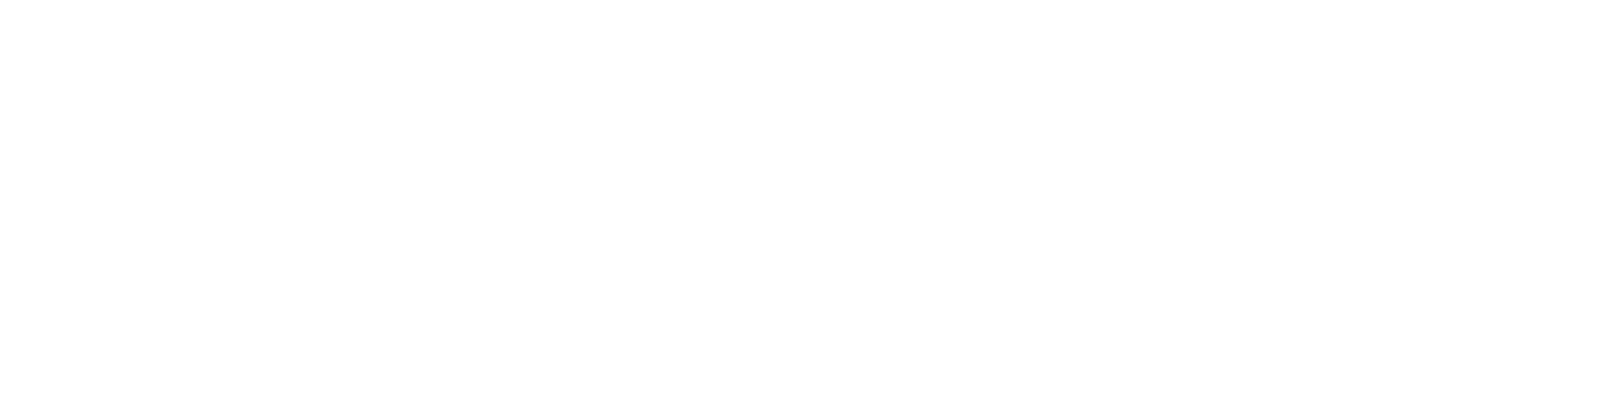

id: 006f290c-7280-491b-b7d7-971ed82de1a5 entities: 86


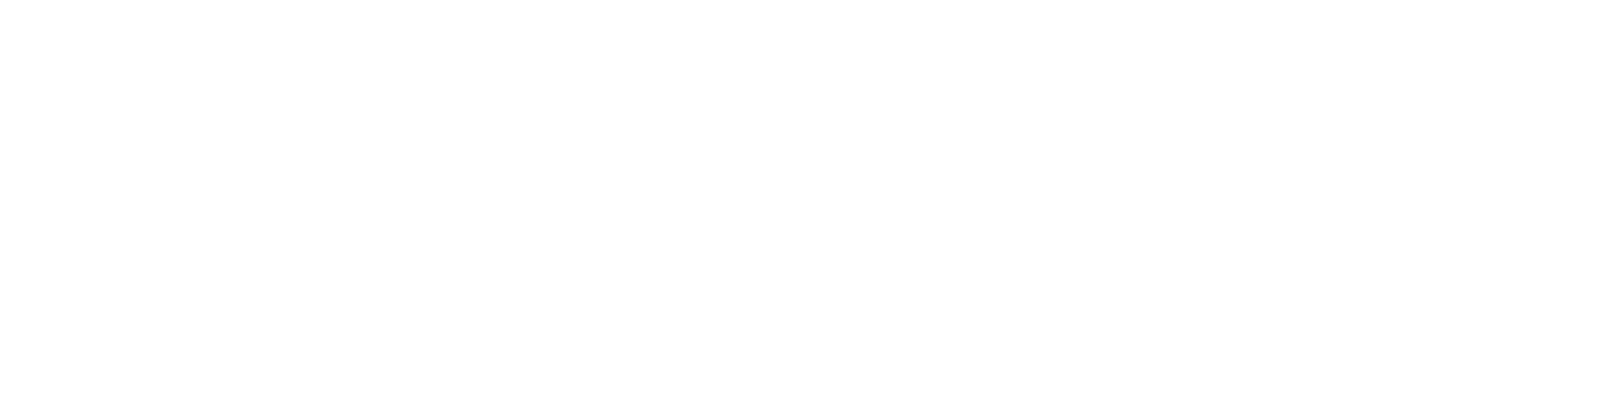

id: 006f290c-7280-491b-b7d7-971ed82de1a5 entities: 42


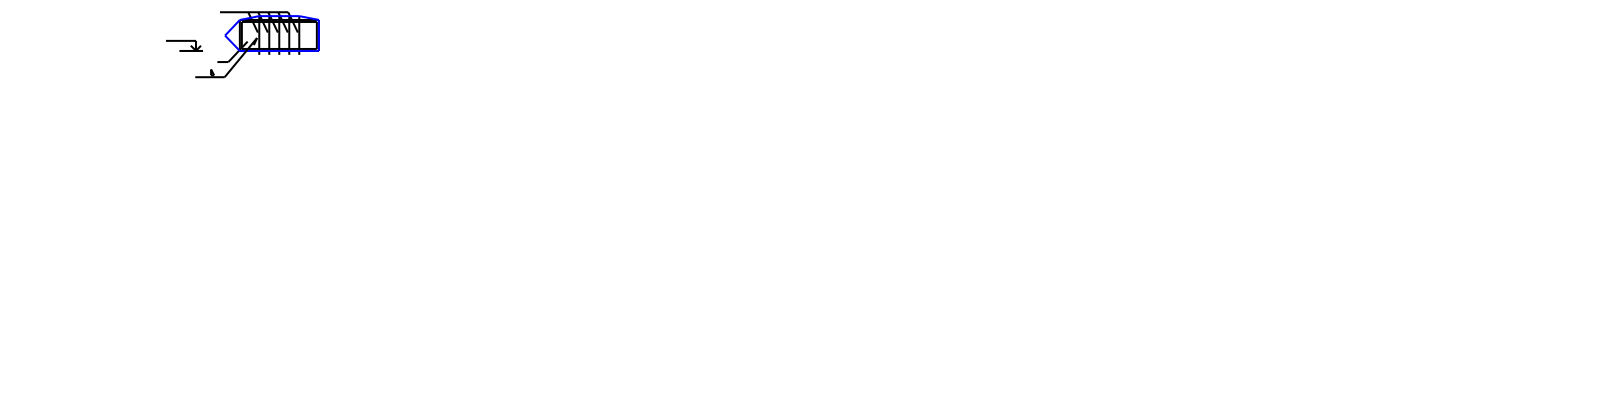

id: 006f290c-7280-491b-b7d7-971ed82de1a5 entities: 62


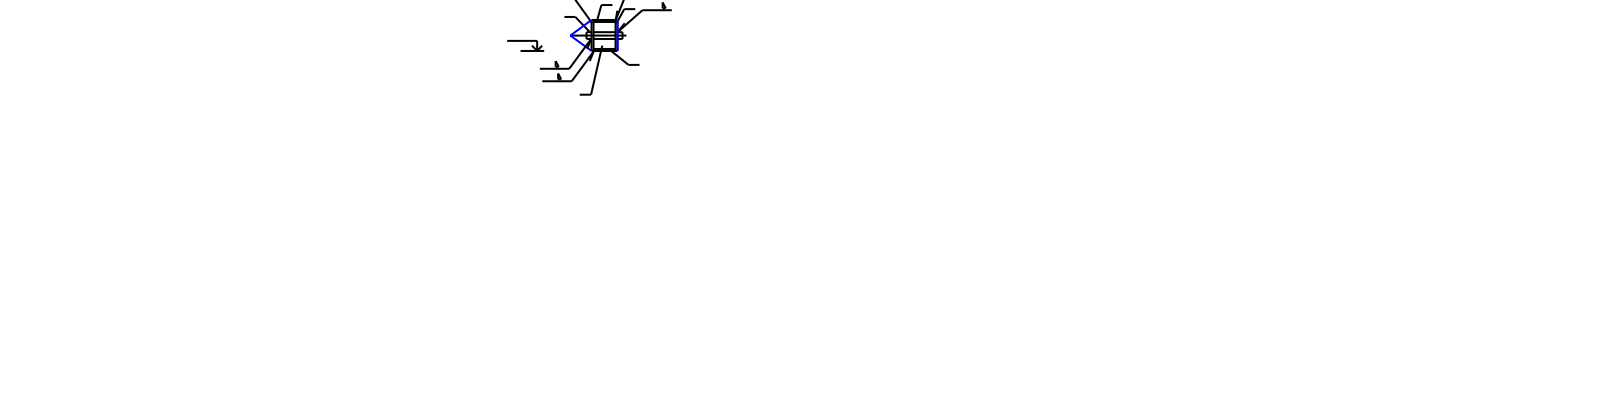

In [23]:
from IPython.display import Image
from IPython.display import clear_output
from plot_graphics import generate_file
    
g = dwg_dataset.entities.data_frame.groupby(['FileId', 'label'])
for kkk in list(g.groups.keys()):
    if kkk[0] in ['006f290c-7280-491b-b7d7-971ed82de1a5', '006f290c-7280-491b-b7d7-971ed82de1a5']:
        chunk = g.get_group(kkk)
        dr = generate_file(chunk, save_file=False, verbose=False)
        display(dr)

entities: 36


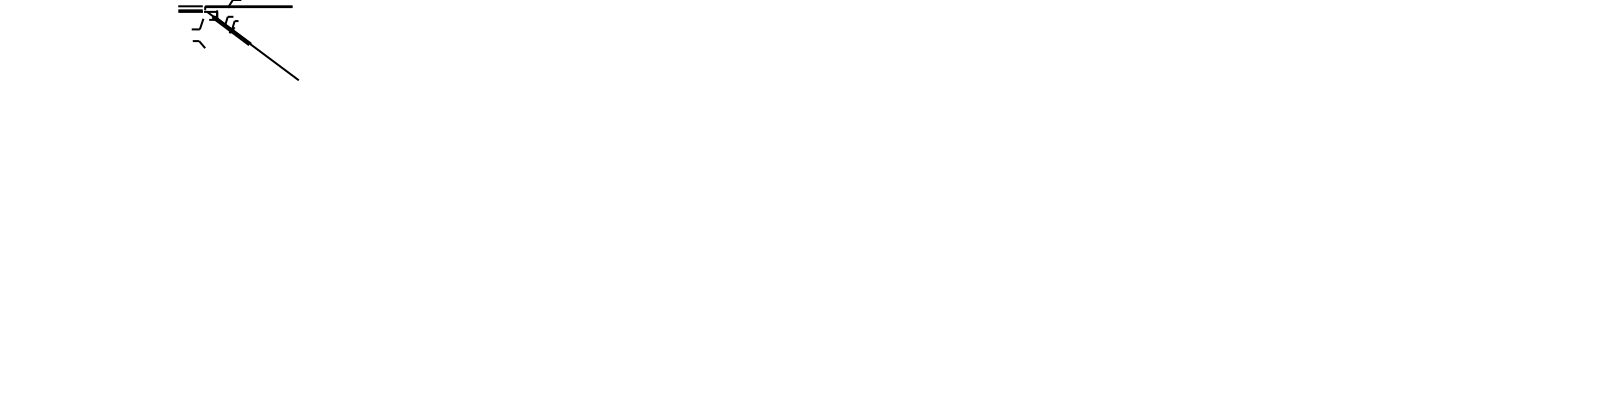

entities: 13


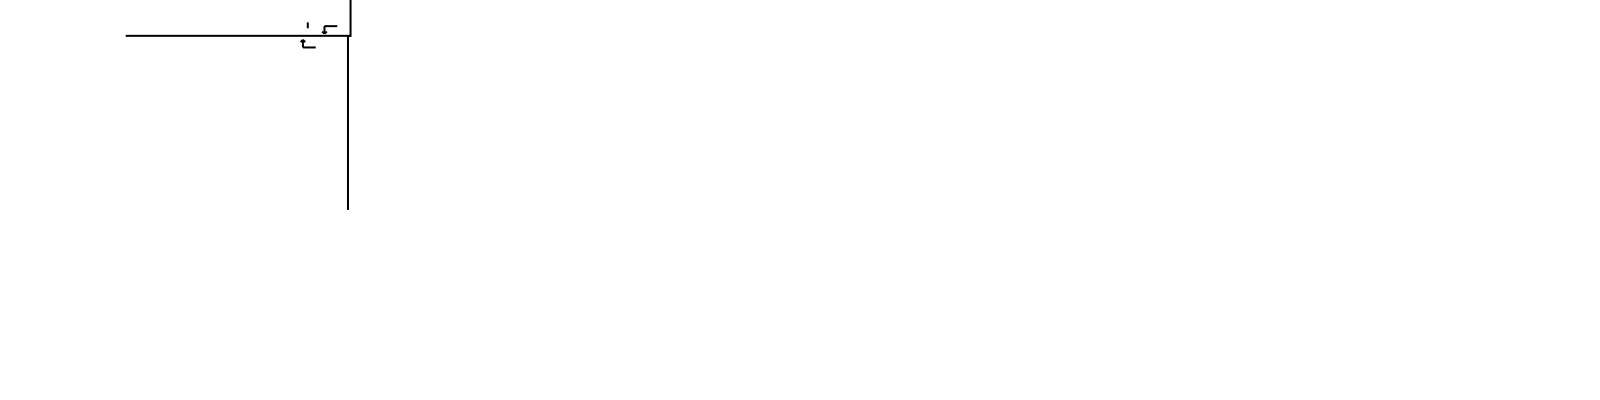

entities: 45


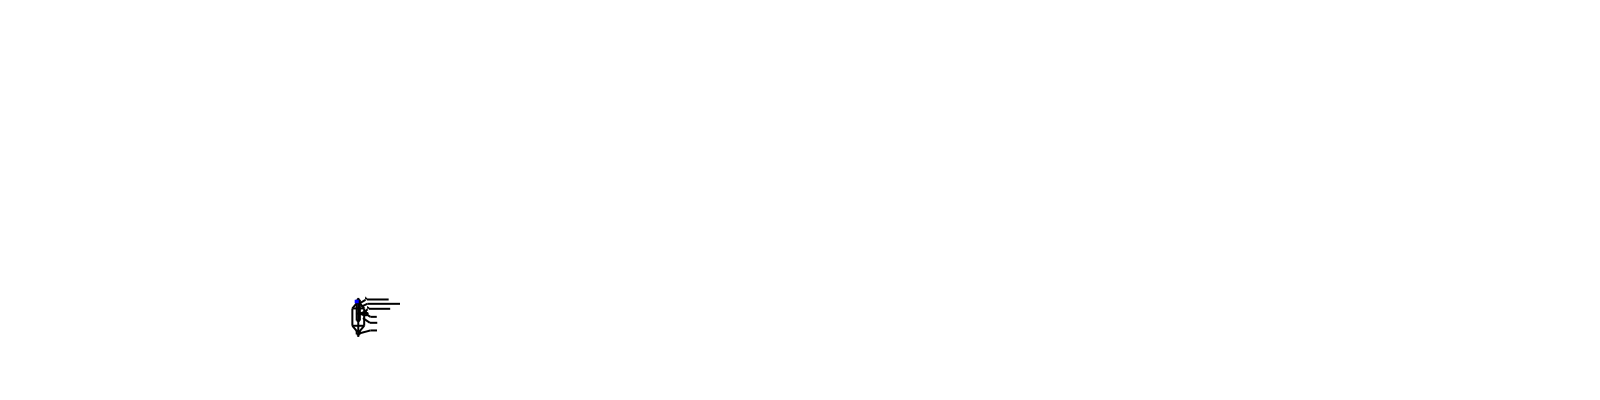

entities: 23


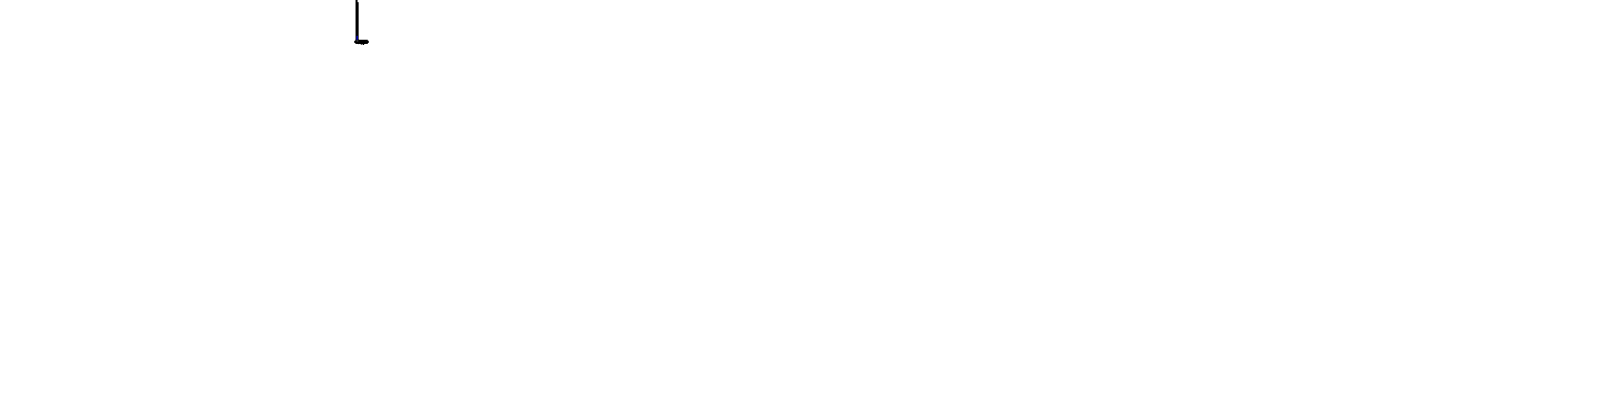

entities: 27


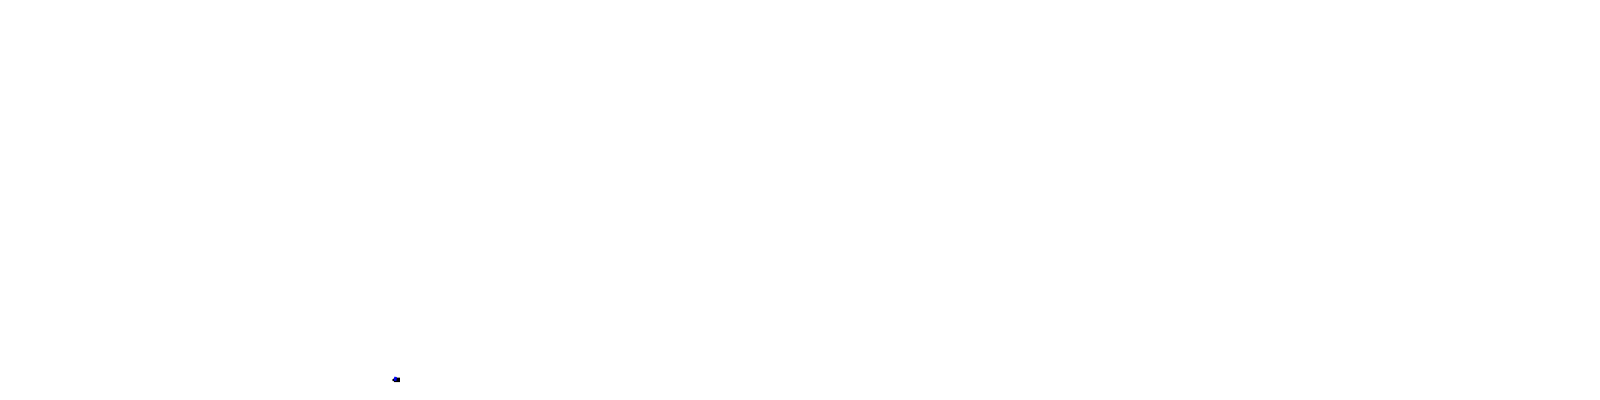

entities: 59


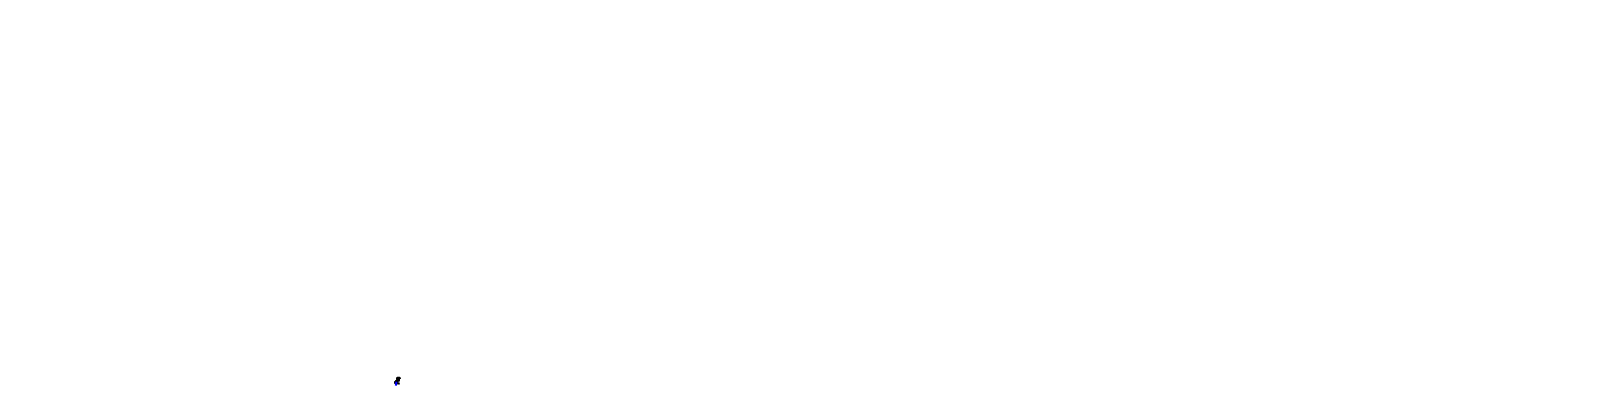

entities: 1180


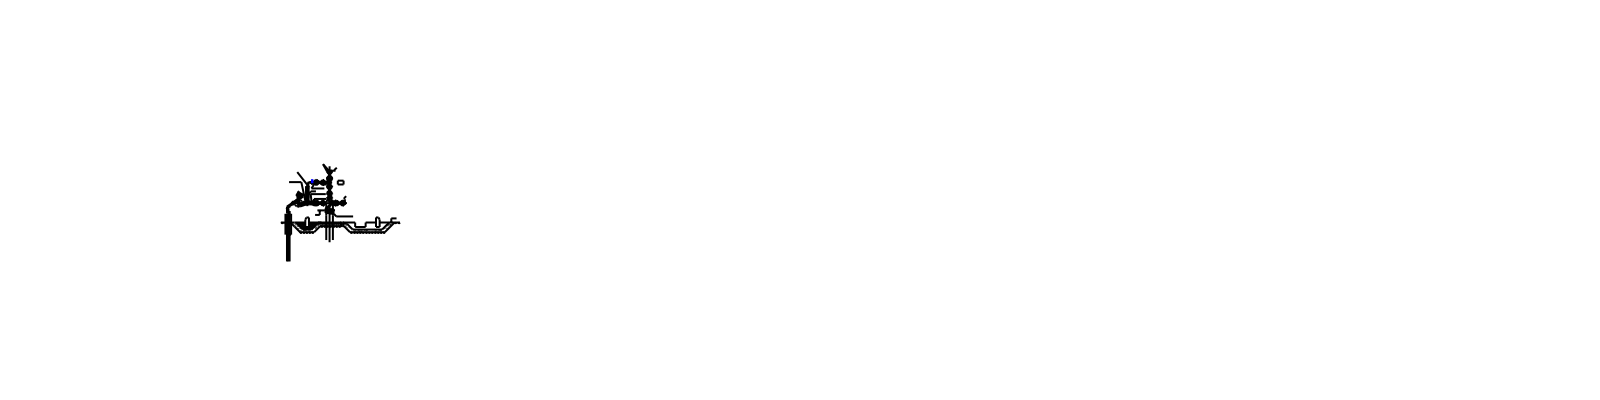

entities: 3051


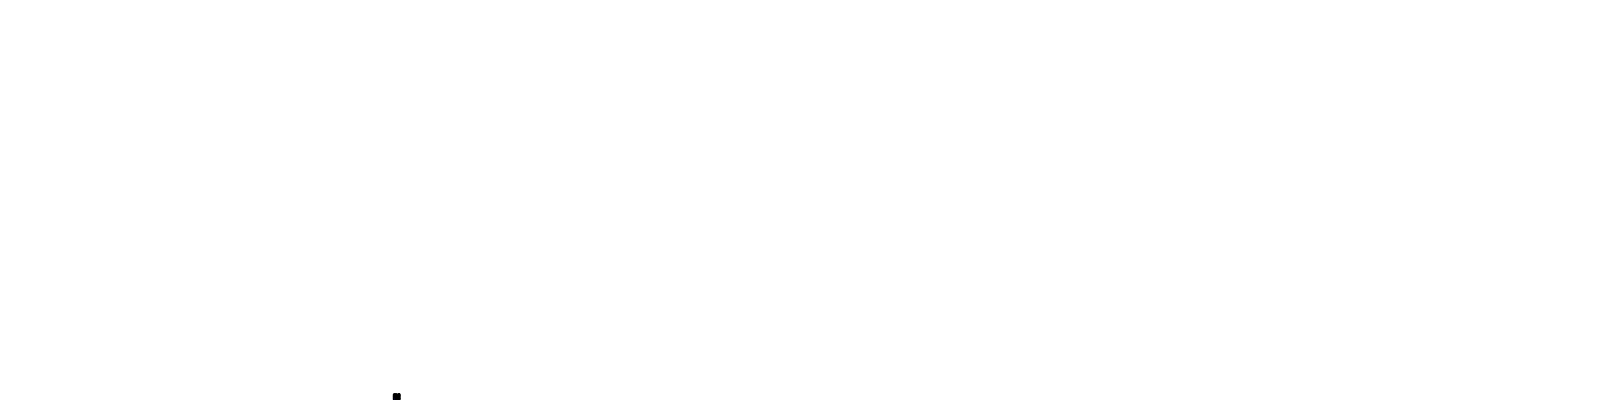

entities: 228


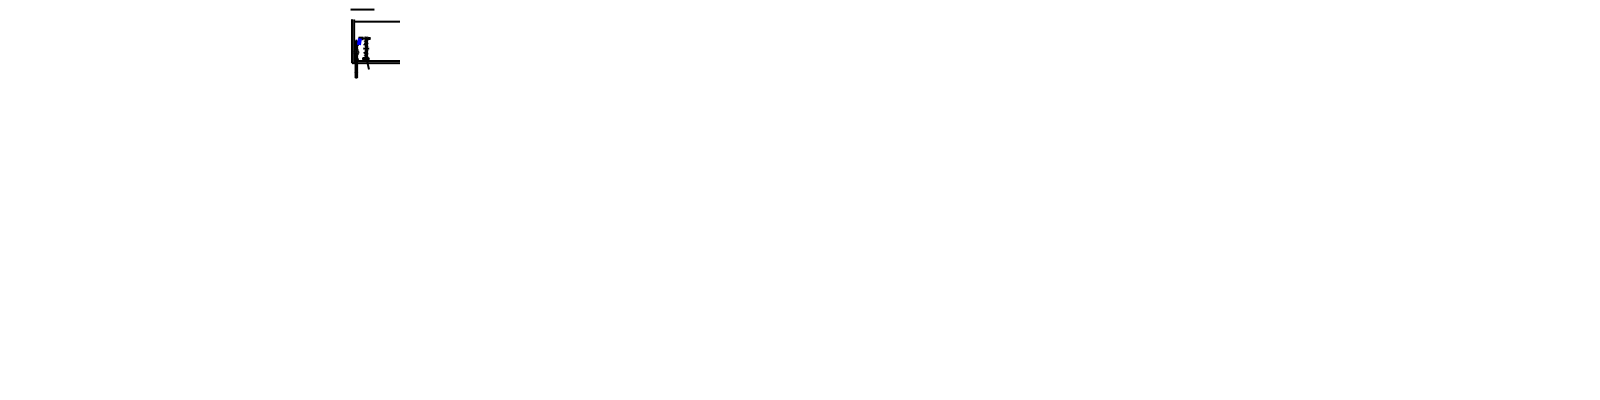

entities: 27


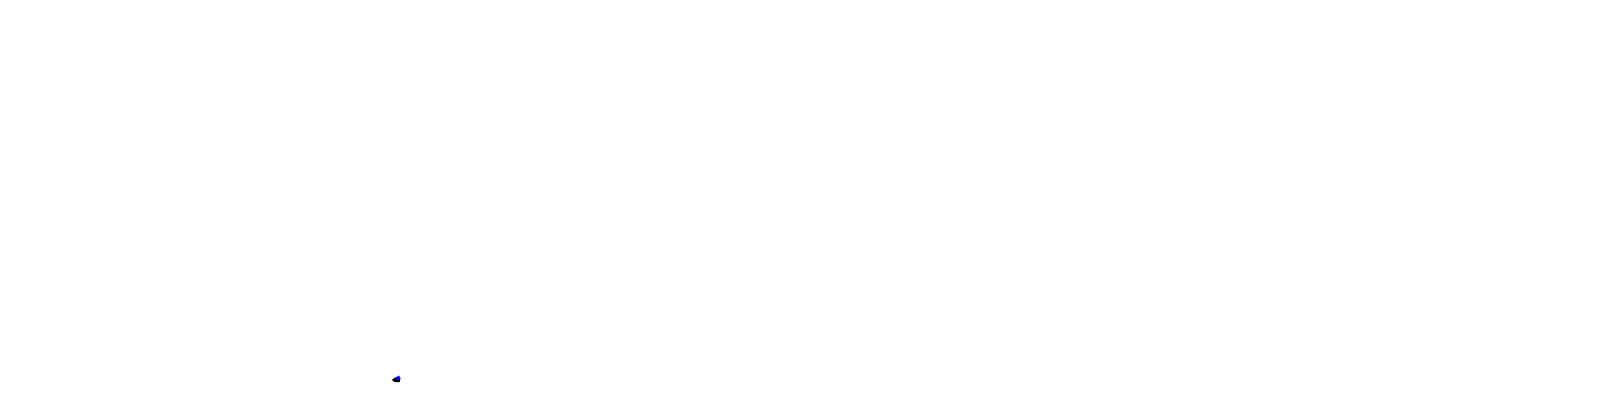

entities: 1027


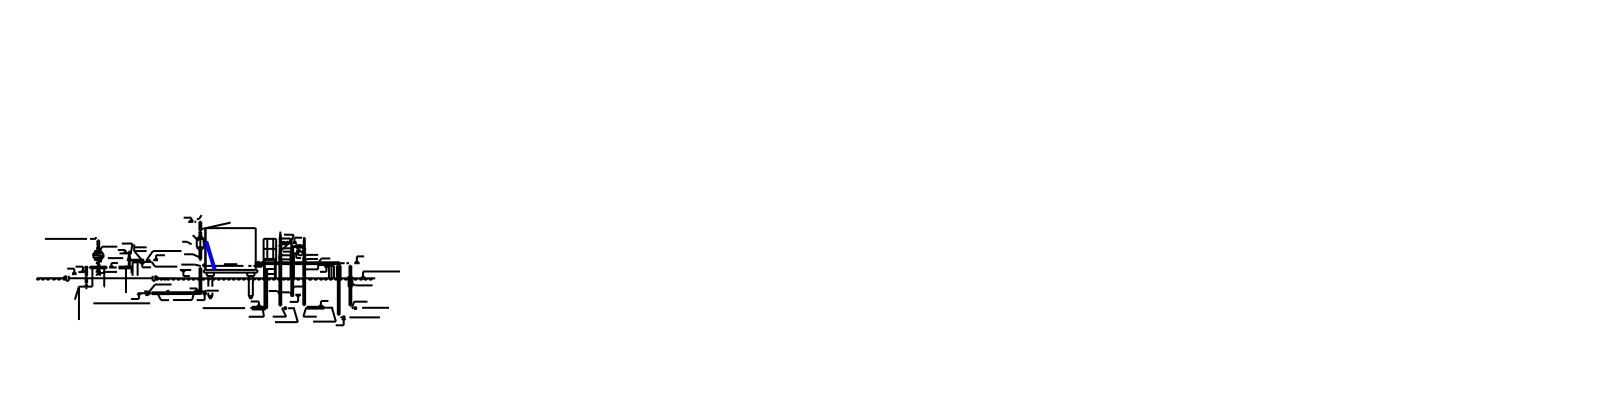

entities: 3051


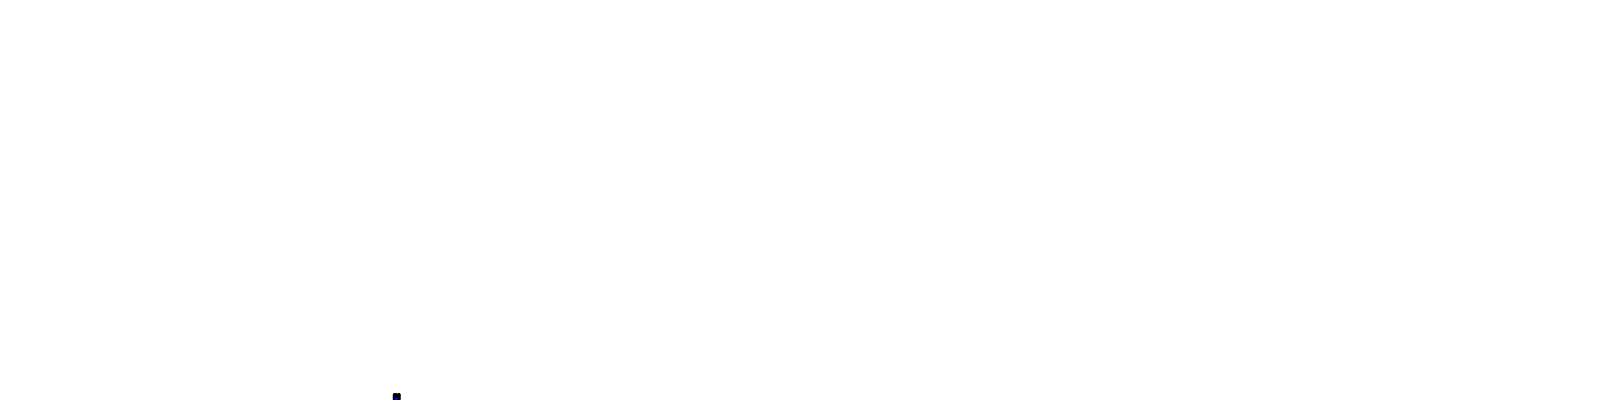

entities: 468


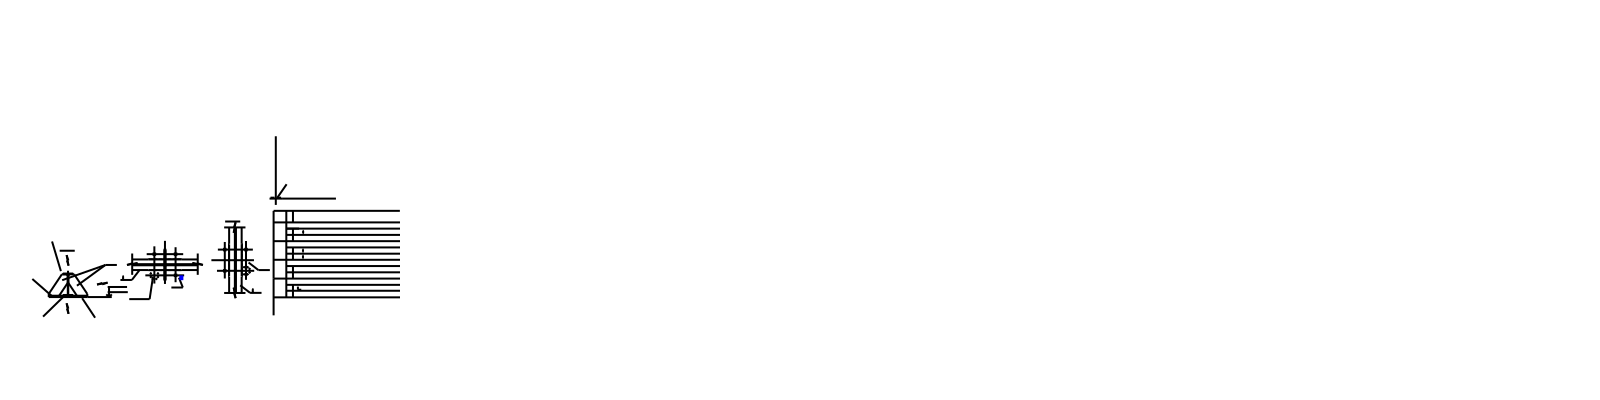

entities: 12


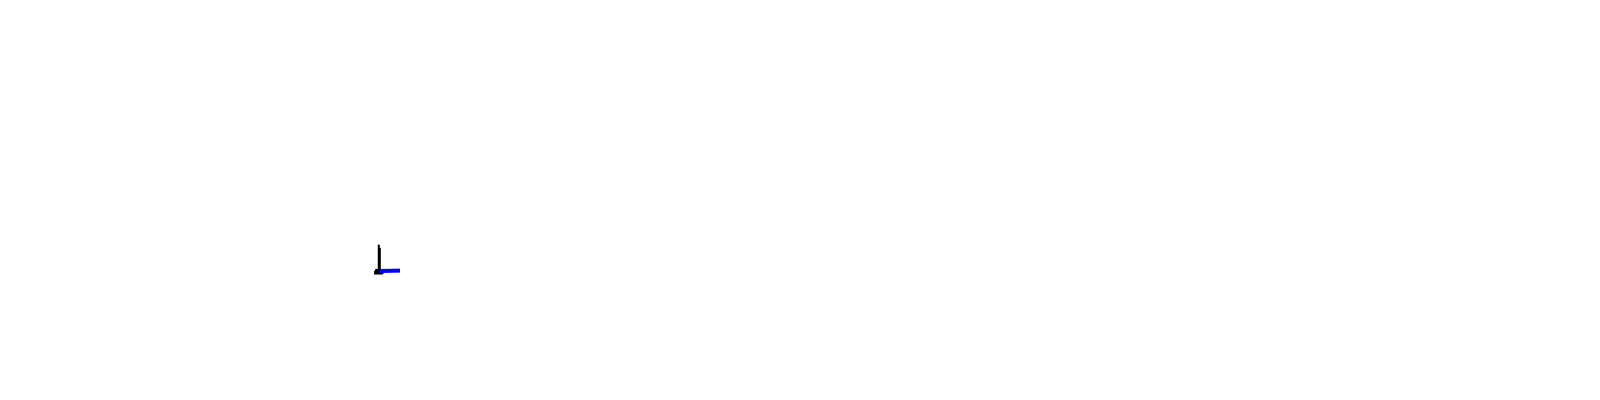

entities: 1180


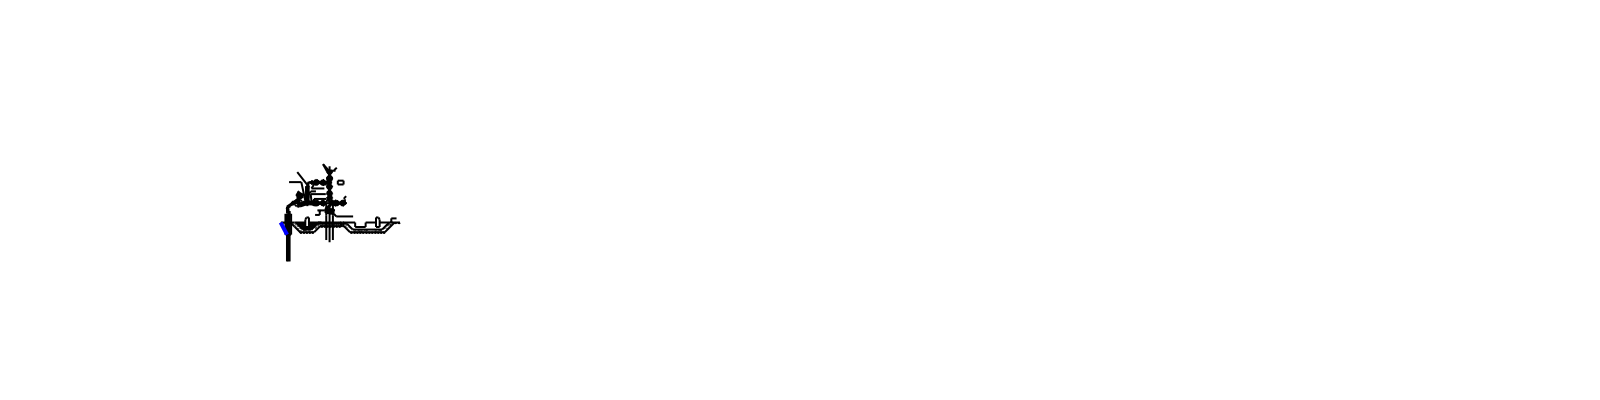

entities: 1027


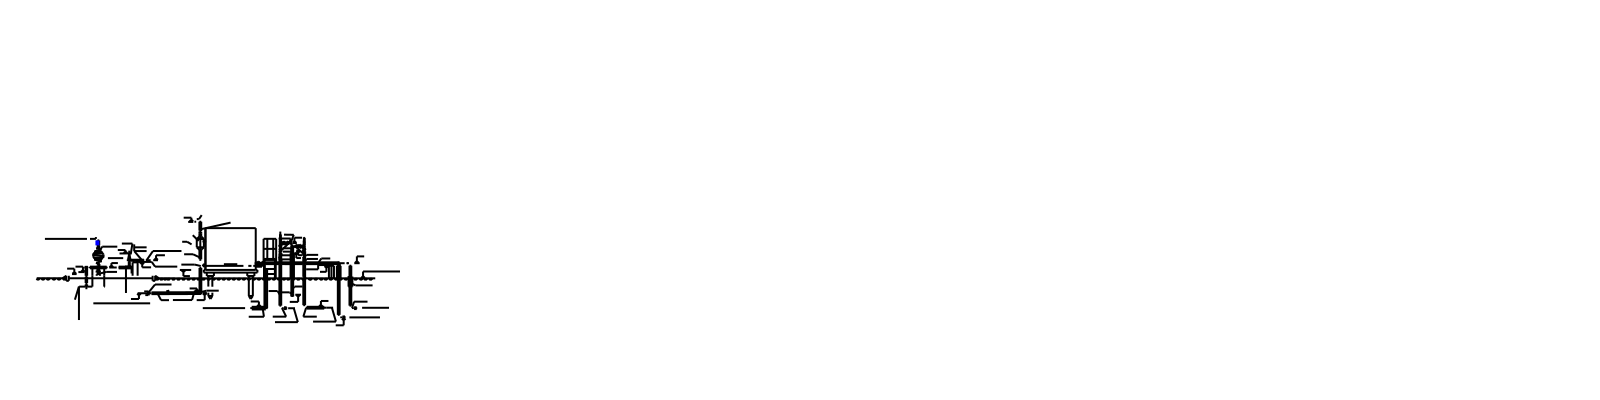

entities: 48


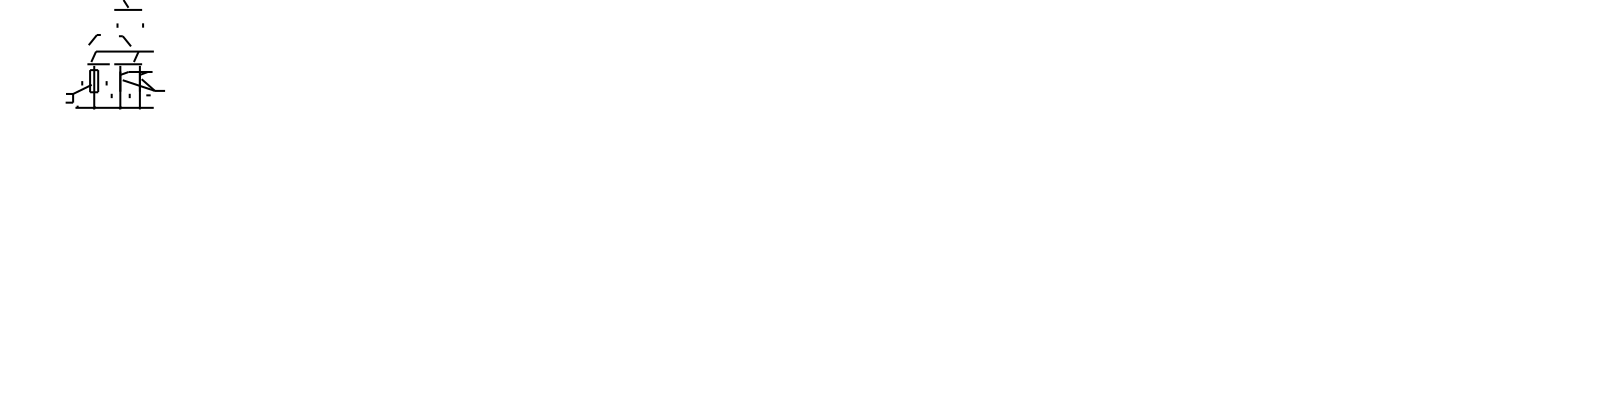

entities: 3051


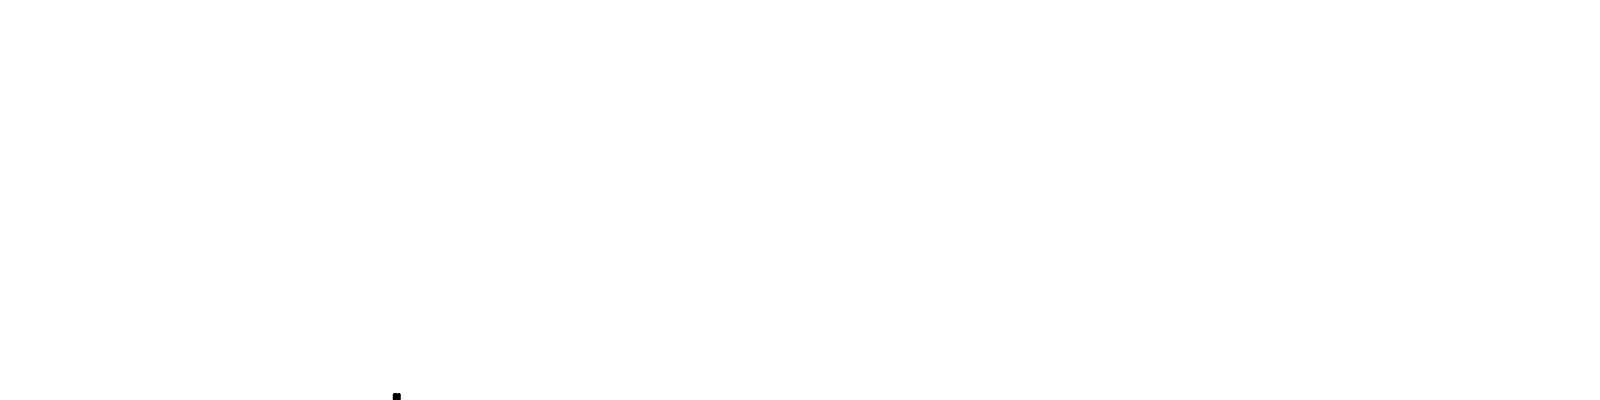

entities: 80


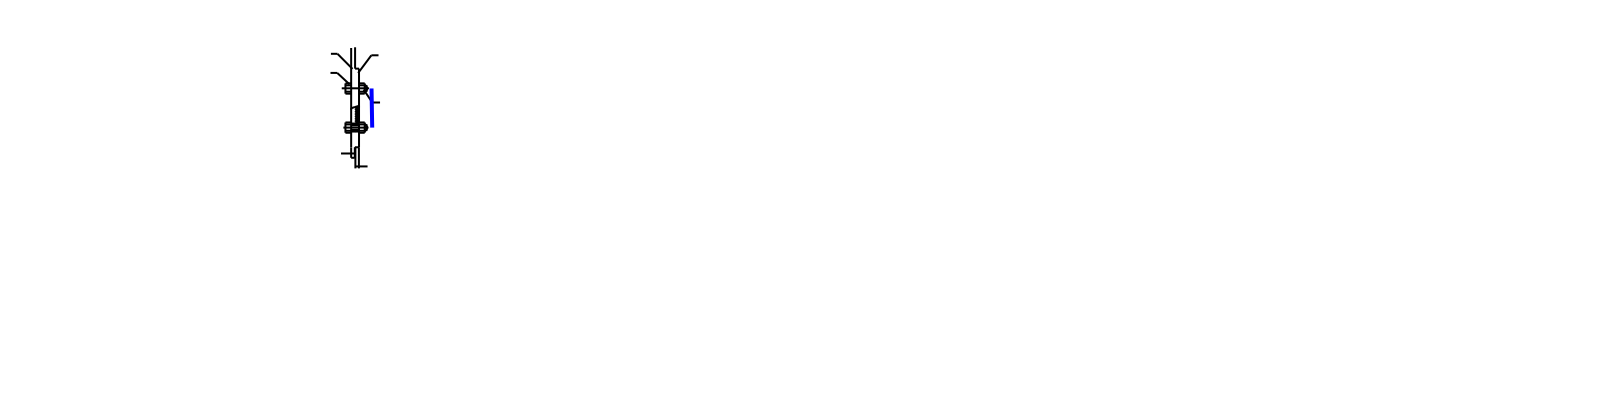

entities: 71


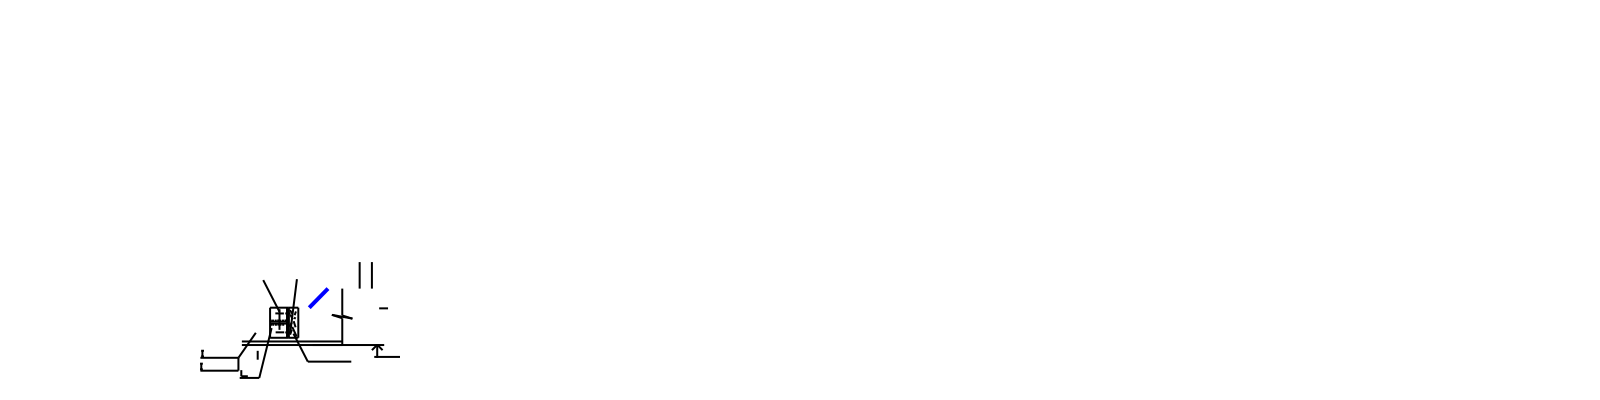

entities: 19


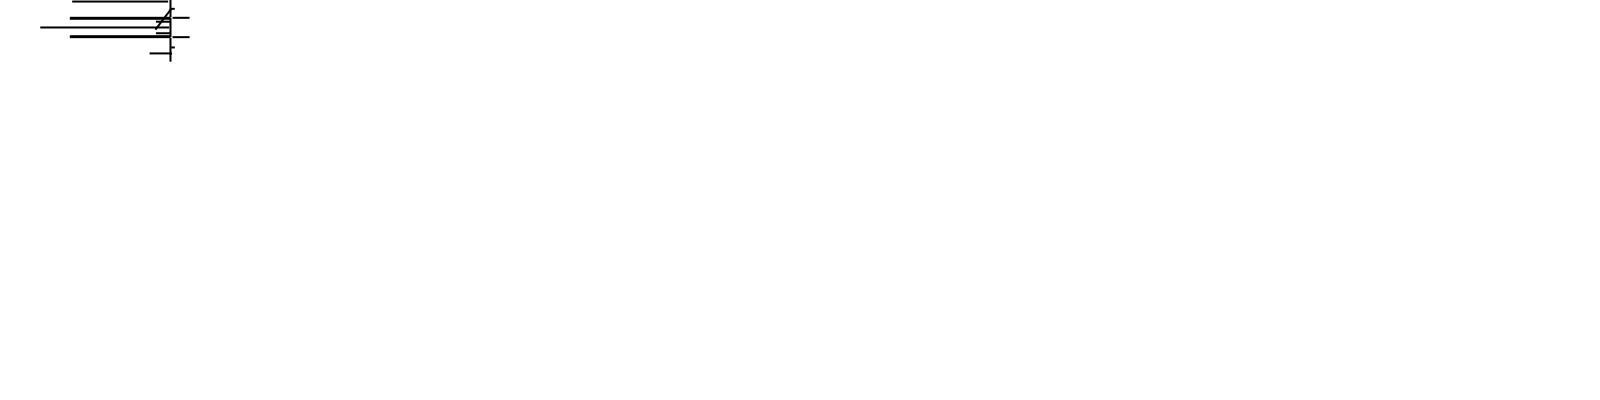

entities: 468


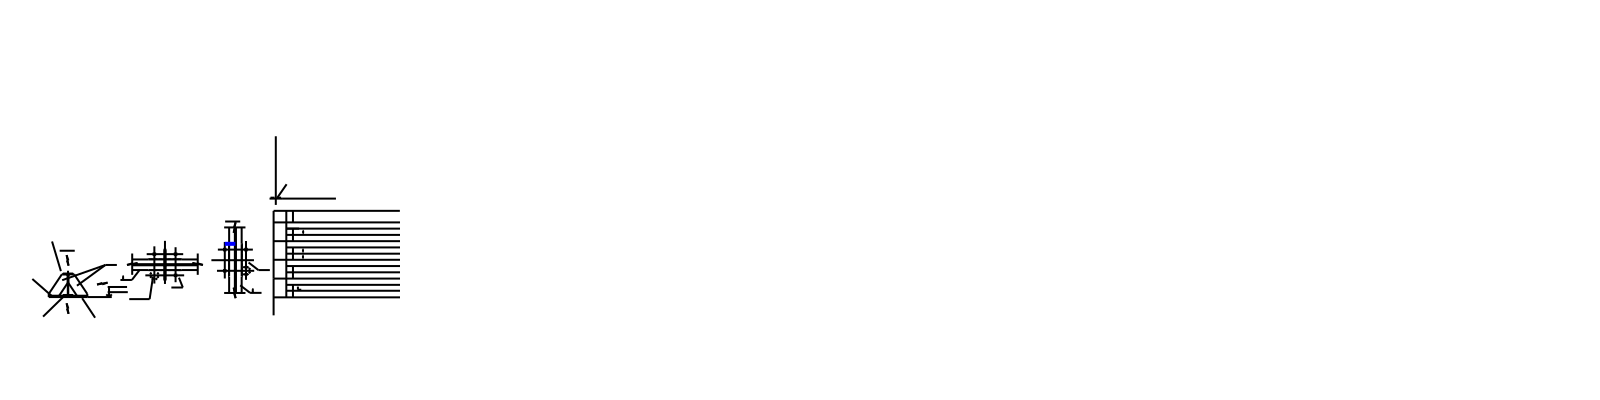

entities: 81


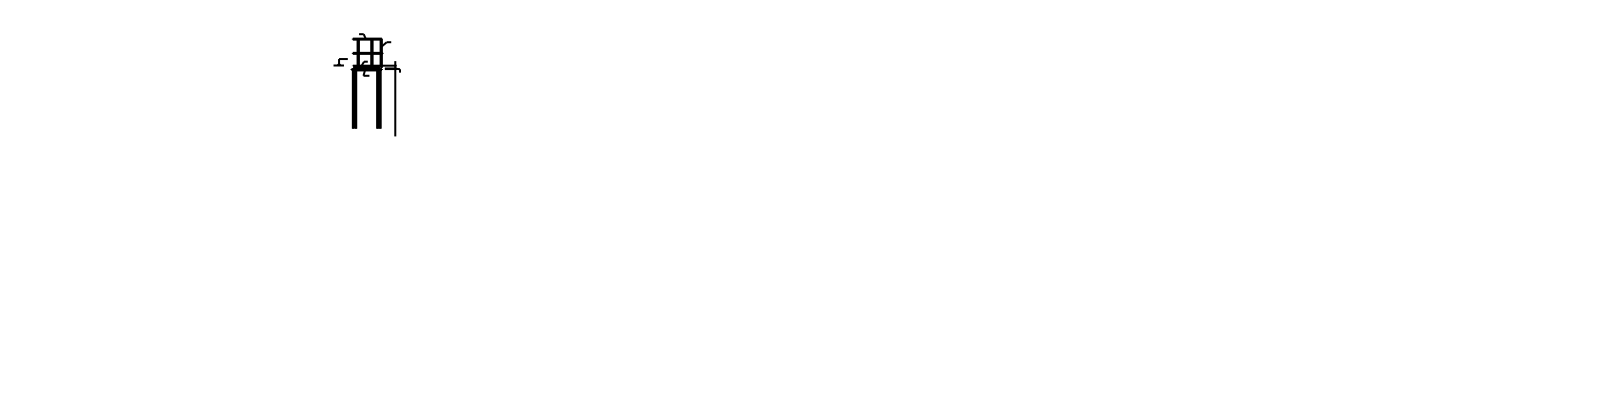

entities: 118


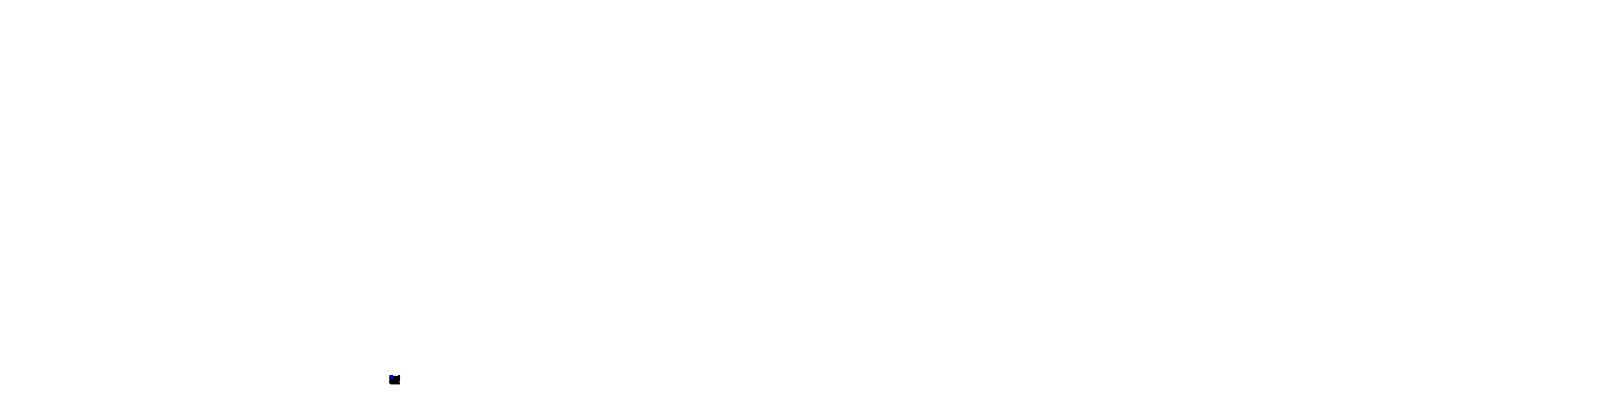

entities: 28


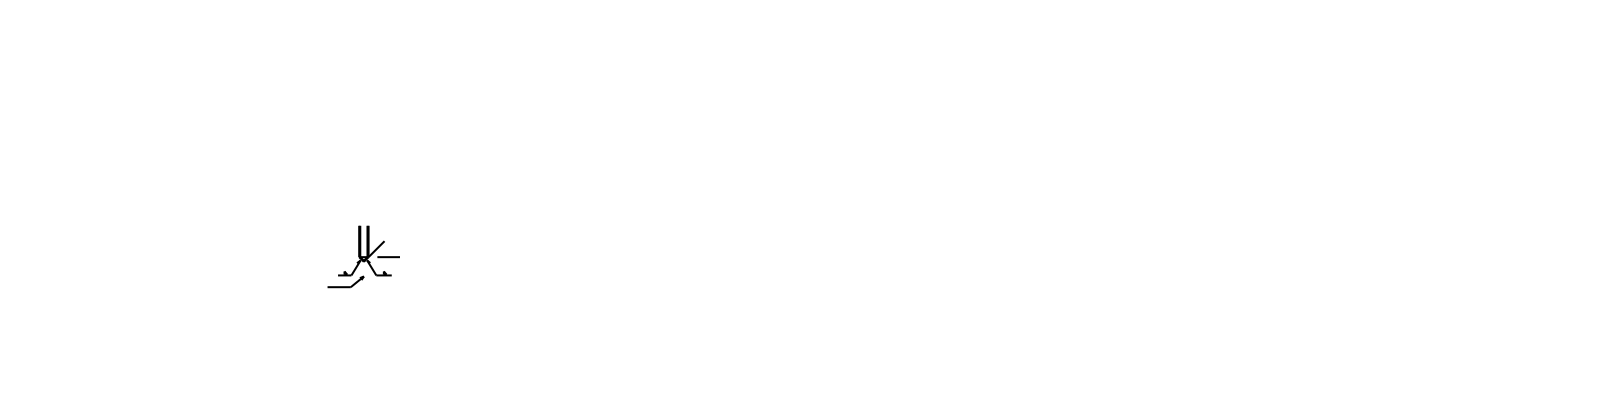

entities: 151


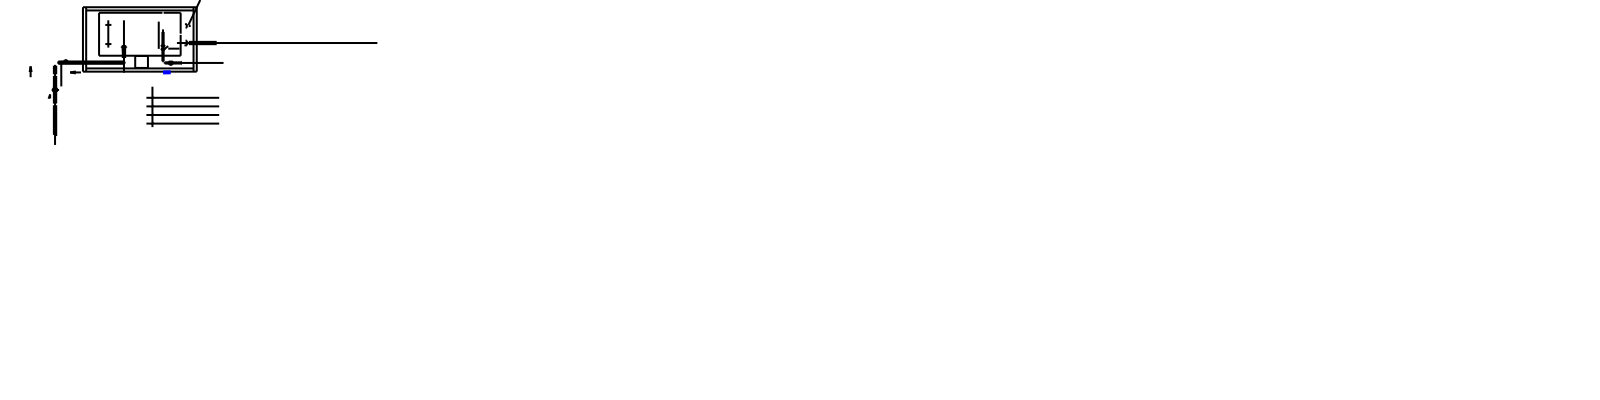

entities: 74


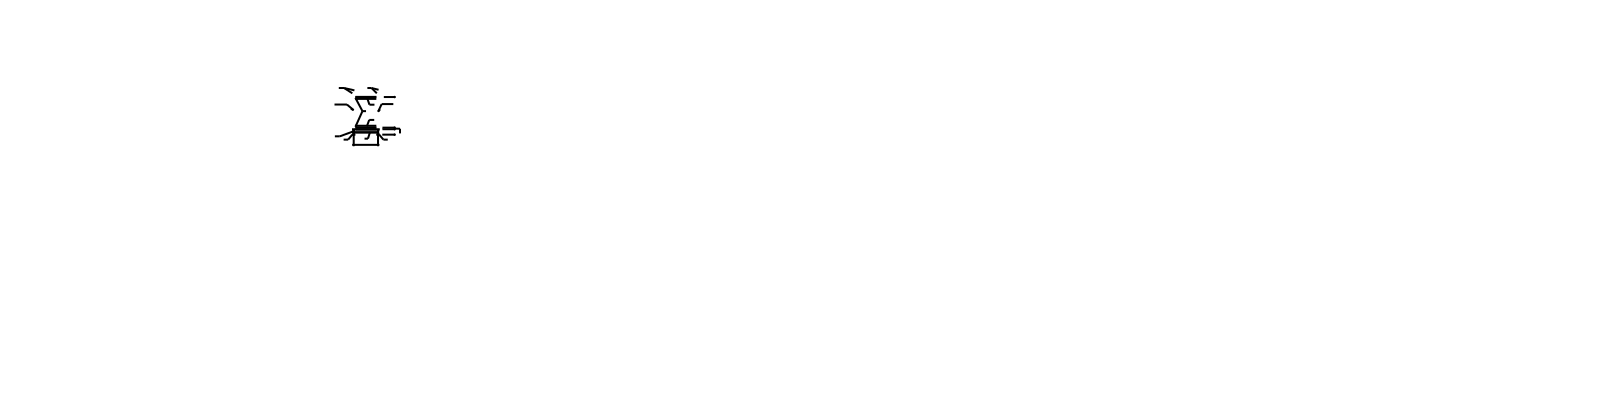

entities: 33


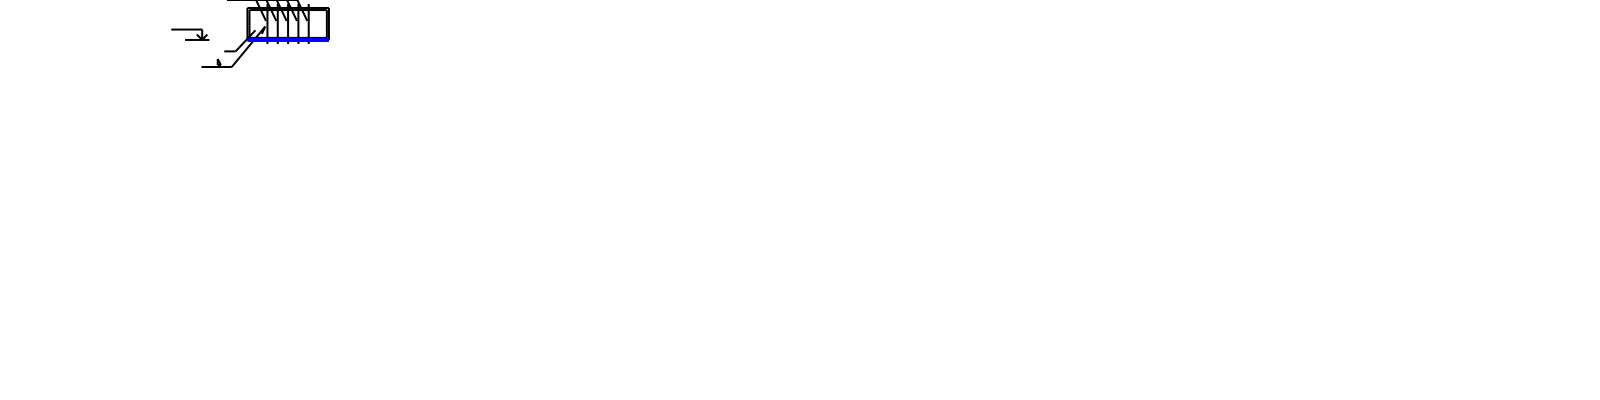

entities: 23


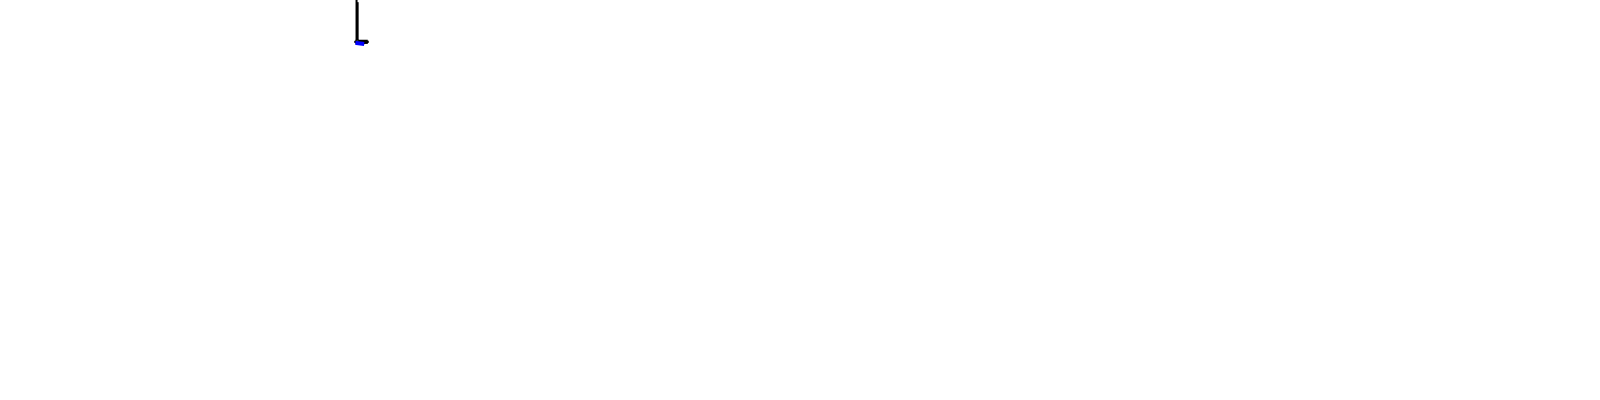

entities: 1082


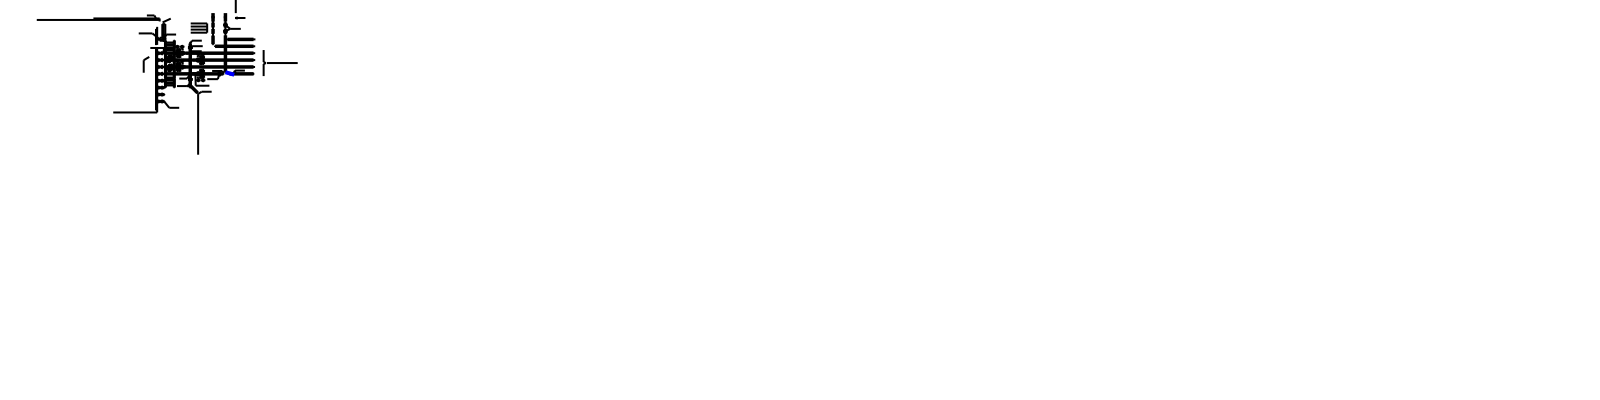

entities: 33


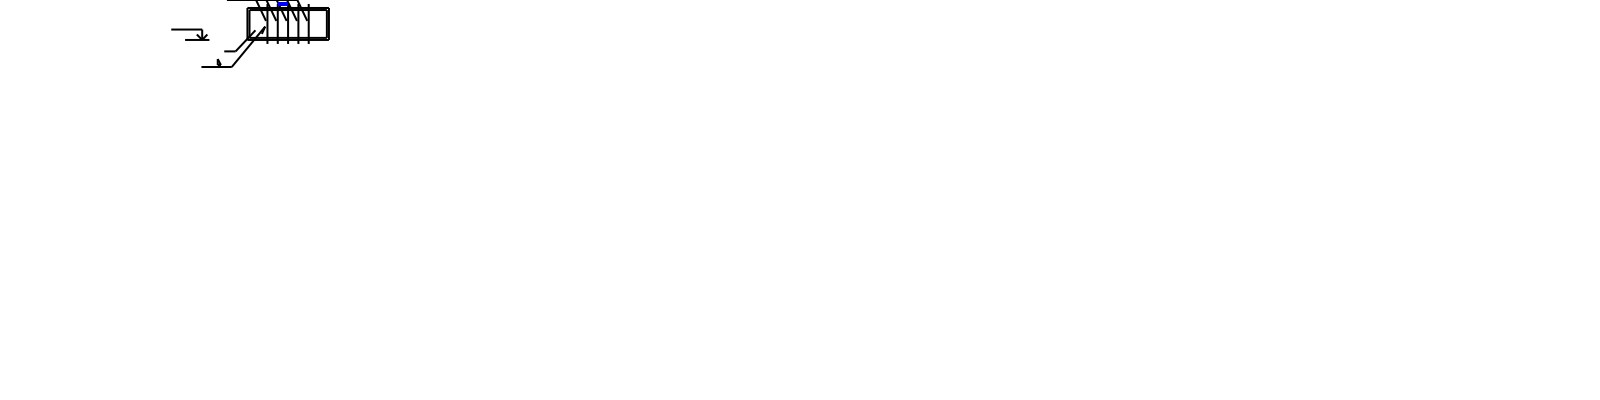

entities: 1014


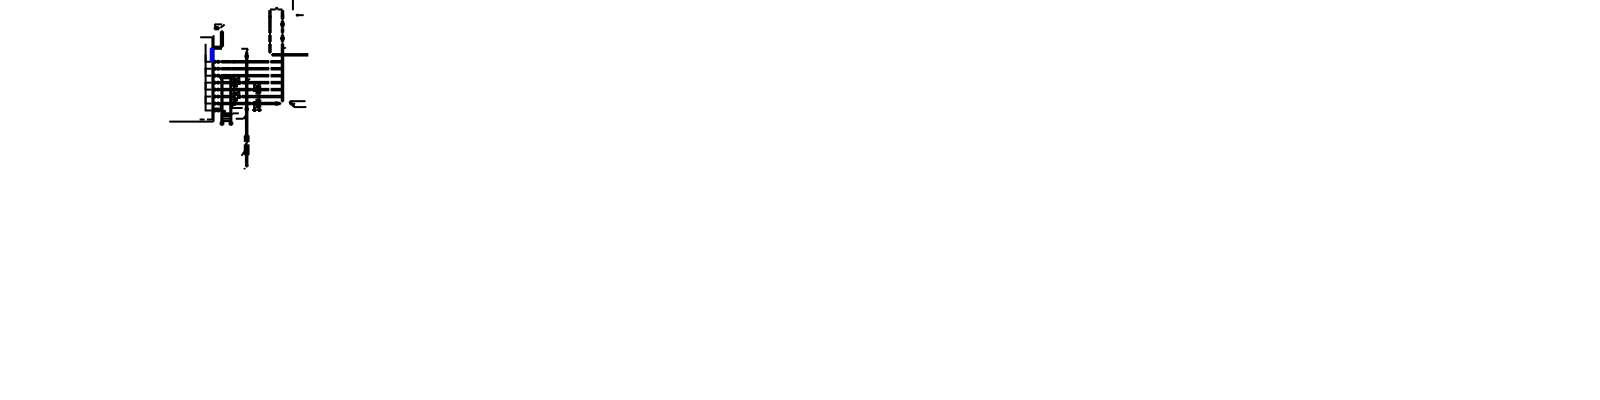

In [25]:
from plot_graphics import draw_sample

j=0
for (x, y) in iter(dwg_dataset.train_loader):
    # print(x,y)
    for i in range(len(x)):
        # print(x[i].shape, y[i])
        display(draw_sample(x[i],y[i]))
        j+=1
    if j>3:
        break